# CS-GY 6053: Foundation of Data Science 
### Title: Exploratory Analysis of New York City Uber Data to Predict Pickup Surges on a US Holiday.




#### Megha Sharma : ms11342
#### Rahul Manjunath Ashlesh: rma460

### Problem Statement:
Predict locations in New York City with the best potential to get a ride request for an Uber cab driver for a given hour of the day, on a US holiday.


In [ ]:
# import all dependencies
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import mplleaflet as mpl

from mpl_toolkits.basemap import Basemap
from matplotlib import cm
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

## Data Preparation
#### We have used New York City Uber data set for the year 2014 from:

* https://www.kaggle.com/fivethirtyeight/uber-pickups-in-new-york-city


In [ ]:
rides_sept = pd.read_csv('uber-raw-data-sep14.csv')
rides_sept = rides_sept.drop(columns='Base')
rides_sept.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028136 entries, 0 to 1028135
Data columns (total 3 columns):
Date/Time    1028136 non-null object
Lat          1028136 non-null float64
Lon          1028136 non-null float64
dtypes: float64(2), object(1)
memory usage: 23.5+ MB


### Data preprocessing
* The 'uber-raw-data-sep14.csv'  data was loaded to a Pandas dataframe.
* Dropped columns which were not used in this analysis, to optimize data size.
* Checked and for NAN values in the dataframe and found none.
* Created new columns Month, day, hour and min using the timestamp column.
* Converted the data types as per the model we used in the subsequent steps.
 

In [ ]:
rides_sept.columns = ['timestamp', 'lat', 'lon']
rides_sept['timestamp'] = pd.to_datetime(rides_sept['timestamp'])

In [ ]:
rides_sept['weekday'] = rides_sept.timestamp.dt.weekday_name
rides_sept['month'] = rides_sept.timestamp.dt.month
rides_sept['day'] = rides_sept.timestamp.dt.day
rides_sept['hour'] = rides_sept.timestamp.dt.hour
rides_sept['minute'] = rides_sept.timestamp.dt.minute
rides_sept.head()


,timestamp,lat,lon,weekday,month,day,hour,minute
0,2014-09-01 00:01:00,40.2201,-74.0021,Monday,9,1,0,1
1,2014-09-01 00:01:00,40.7500,-74.0027,Monday,9,1,0,1
2,2014-09-01 00:03:00,40.7559,-73.9864,Monday,9,1,0,3
3,2014-09-01 00:06:00,40.7450,-73.9889,Monday,9,1,0,6
4,2014-09-01 00:11:00,40.8145,-73.9444,Monday,9,1,0,11


# Studying patters in the data

#### Hourly Data
We used the below data to study and analise the average rides for all the days in 24 hours.

In [ ]:
day_map = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
rides_sept['weekday'] = pd.Categorical(rides_sept['weekday'], categories=day_map, ordered=True)

## groupby operation
hourly_ride_data = rides_sept.groupby(['day','hour','weekday'])['timestamp'].count()

## reset index
hourly_ride_data = hourly_ride_data.reset_index()

## rename column
hourly_ride_data = hourly_ride_data.rename(columns = {'timestamp':'ride_count'})

## ocular analysis
hourly_ride_data.head()

,day,hour,weekday,ride_count
0,1,0,Monday,699
1,1,1,Monday,490
2,1,2,Monday,363
3,1,3,Monday,333
4,1,4,Monday,261


#### Weekday data
We did this to study and analise the average rides for for each day of the week.

In [ ]:
## groupby operation
weekday_hourly_avg = hourly_ride_data.groupby(['weekday','hour'])['ride_count'].mean()

## reset index
weekday_hourly_avg = weekday_hourly_avg.reset_index()

## rename column
weekday_hourly_avg = weekday_hourly_avg.rename(columns = {'ride_count':'average_rides'})

## sort by categorical index
weekday_hourly_avg = weekday_hourly_avg.sort_index()

## ocular analysis
weekday_hourly_avg.head()

,weekday,hour,average_rides
0,Monday,0,377.0
1,Monday,1,240.2
2,Monday,2,195.4
3,Monday,3,356.0
4,Monday,4,495.8


## Plotting all the average ride in an hour for all Mondays in september 2014

In [ ]:
Monday_hourly_data = hourly_ride_data[hourly_ride_data['weekday']=='Monday']

Text(0.5, 0, 'Hour')

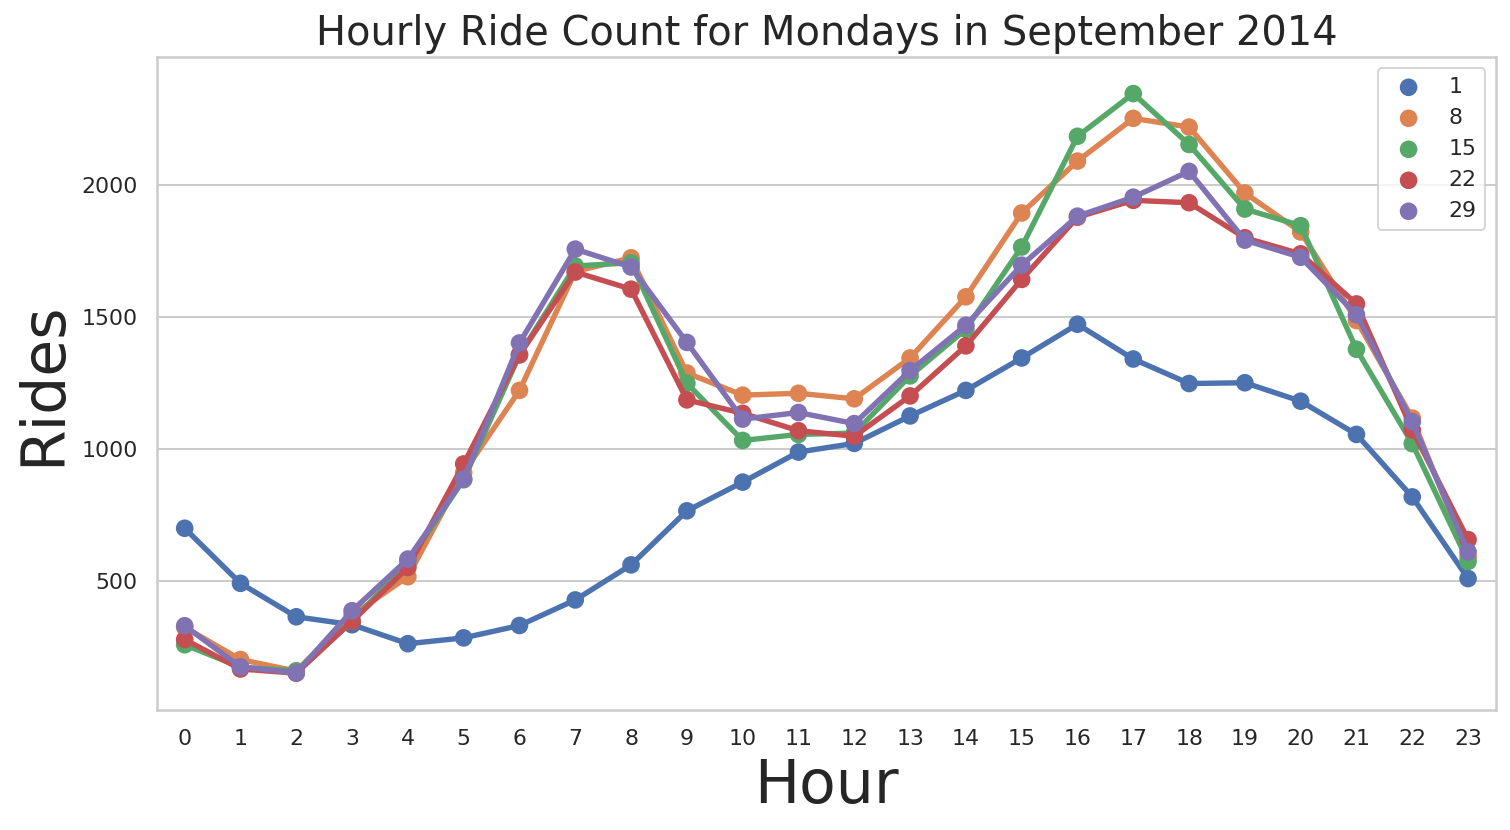

In [ ]:
## create figure
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

## set palette   
#current_palette = sns.color_palette(tableau_color_blind)

## plot data
sns.pointplot(ax=ax, x='hour',y='ride_count',hue='day',  data = Monday_hourly_data)

## clean up the legend
l = ax.legend()
l.set_title('')

## format plot labels
ax.set_title('Hourly Ride Count for Mondays in September 2014', fontsize=20)
ax.set_ylabel('Rides', fontsize=30)
ax.set_xlabel('Hour', fontsize=30)

* Visualizing the Labour day September 1, 2014 we noticed a very distinct variation in the number and time of rides when compared to other Mondays in the same month. 

## Heat map

In [ ]:
def heat_map(ax_loc,title_str,rides_this_hour,nsew):
    
    ## get the axis
    ax = fig.add_subplot(ax_loc)
   
    ## make the basemap object
    m = Basemap(projection='merc', urcrnrlat=nsew[0], llcrnrlat=nsew[1], urcrnrlon=nsew[2], llcrnrlon=nsew[3], lat_ts=nsew[1], resolution='f')

    ## draw the background features
    m.drawmapboundary(fill_color = 'xkcd:light blue')
    m.fillcontinents(color='xkcd:green', zorder = 1)
    m.drawcoastlines()
    m.drawrivers()

    ## project the GPS coordinates onto the x,y representation
    x, y = m(rides_this_hour['lon'].values, rides_this_hour['lat'].values)

    ## count the instances using the hexbin method and plot the results
    m.hexbin(x, y, gridsize=1000, mincnt = 1, bins = 'log', cmap=cm.YlOrRd, zorder = 2);

    ## set the title
    ax.set_title(title_str, fontsize=24)

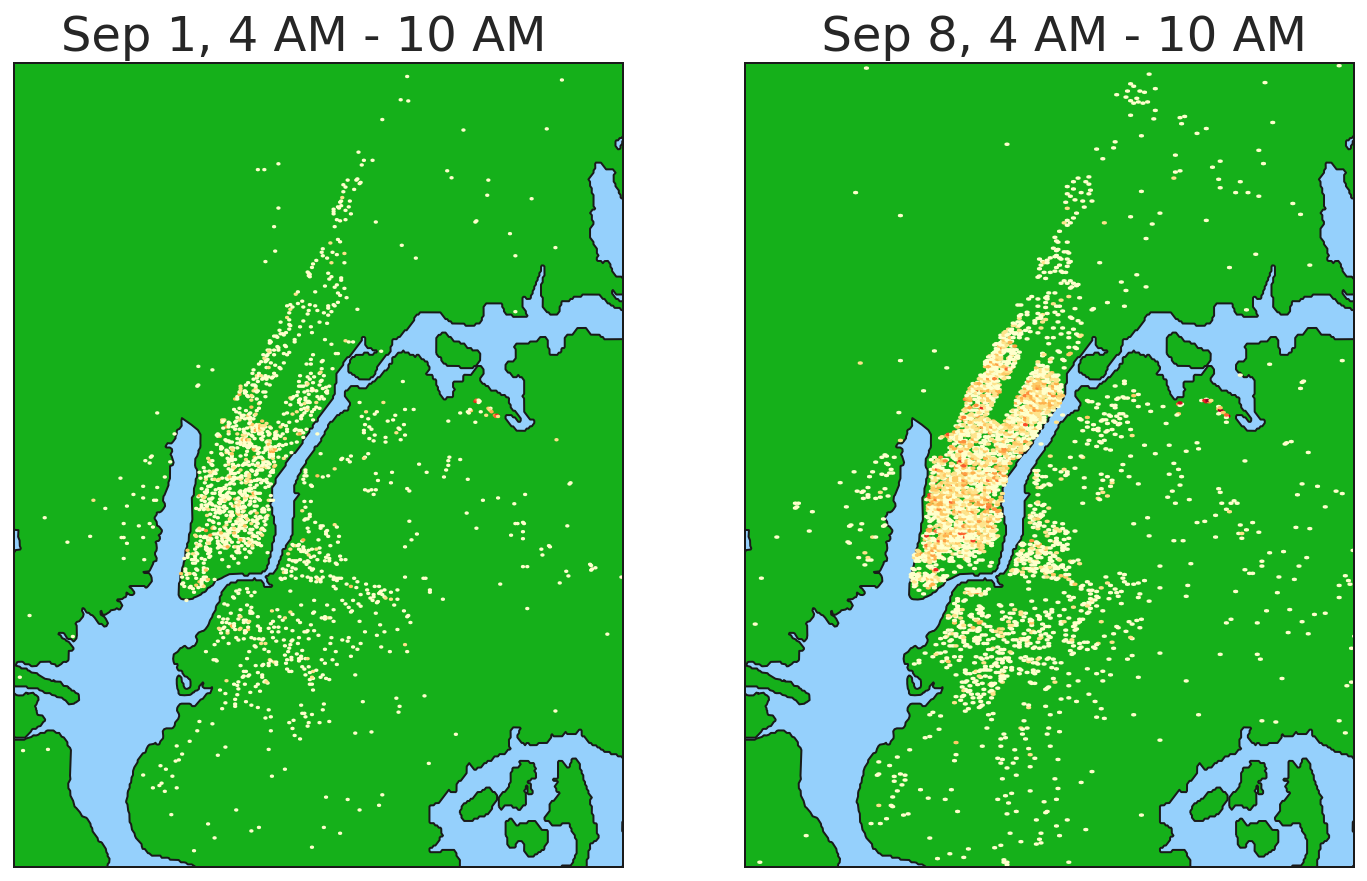

In [ ]:
labour_day = [1, 8]

## north,south,east,west lat/lon coordinates for bounding box
nsew = [40.9,40.6,-73.8,-74.1]

## create figure
fig = plt.figure(figsize=(12,12))

## hour 
hrs = 8

## axis locations
ax_loc = [121,122] 

## title strings
title_str = ['Sep 1, 4 AM - 10 AM  ', '  Sep 8, 4 AM - 10 AM']

## plot loop
for ii in range(len(ax_loc)):

    ## get the ride data for 8am - 9am
    rides_this_hour = rides_sept.loc[(rides_sept['day'] == labour_day[ii])  & (rides_sept['hour'] > 4) & (rides_sept['hour'] < 10)]

    ## plot the heat map
    heat_map(ax_loc[ii],title_str[ii],rides_this_hour,nsew)

* We have plotted a heat map for two consecutive Mondays, 1 September (labour day) and 8 September and made the following observations.
* HeatMap Visualisation findings:-
- There are very few rides booked in the Upper East, Upper West and Midtown Manhattan region. This could be a clear indicator of the holiday, where the usual corporate employees in Manhattan may not needing a ride. But other mondays large number of rides were booked in Midtown Manhattan and around Central Park from at 4am-10am.
- Thus we can show that on Labour day there were very sparse pickups around central park, proving out initial assumption in this project. 


## Clustering


In [ ]:
Labour_Day_data = rides_sept[rides_sept['day']==1]

# 5 early morning hours
LD_4_9_hours_data = Labour_Day_data[(LabourDay_data['hour']>=4) & (LabourDay_data['hour']<=9)]  

# 7 morning and noon hours
LD_10_16_hours_data = Labour_Day_data[(LabourDay_data['hour']>=10) & (LabourDay_data['hour']<=16)] 

# 5 eveing
LD_16_21_hours_data = Labour_Day_data[(LabourDay_data['hour']>=16) & (LabourDay_data['hour']<=21)] 

# night 
LD_0_3_22_23_hours_data =  Labour_Day_data[(LabourDay_data['hour']>=0) & (LabourDay_data['hour']<=3) & (LabourDay_data['hour']>=22) & (LabourDay_data['hour']<=23)] 


In [ ]:
import sklearn.metrics as metrics
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

## maximum distance between two cluster members in kilometers is 1.6Km/20blocks  == approx 1 block. (converted to miles)
max_distance = 0.08

## minimum number of cluster members
min_pickups = 10

def get_hot_spots(max_distance,min_cars,ride_data):
    
    ## get coordinates from ride data
    coords = ride_data.as_matrix(columns=['lat', 'lon'])
    
    ## calculate epsilon parameter using user defined distance
    kms_per_radian = 6371.0088
    epsilon = max_distance / kms_per_radian
    
    ## perform clustering
    db = DBSCAN(eps=epsilon, min_samples=min_cars, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    
    ## group the clusters
    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels)) - (1 if -1 in labels else 0)
    clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
    
    noise = list(cluster_labels).count(-1)
    
    #X = ride_data.drop(columns=['timestamp'])
    #X = X.drop(columns=['base'])
    #X = X.drop(columns=['weekday'])
    #X = StandardScaler().fit_transform(X)
    
    ## report
    print('Number of clusters: {}'.format(num_clusters))
    print('Noise: {}'.format(noise))
    #print("Homogeneity: %0.3f" % metrics.homogeneity_score(clusters, num_clusters))
    #print("Completeness: %0.3f" % metrics.completeness_score(labels_true, num_clusters))
    #print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, num_clusters))
    #print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, num_clusters))
    #print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(labels_true, num_clusters))
    #print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score( X,num_clusters))

    
    ## initialize lists for hot spots
    lat = []
    lon = []
    num_members = []
    
    ## loop through clusters and get centroids, number of members
    for ii in range(len(clusters)):

        ## filter empty clusters
        if clusters[ii].any():

            ## get centroid and magnitude of cluster
            lat.append(MultiPoint(clusters[ii]).centroid.x)
            lon.append(MultiPoint(clusters[ii]).centroid.y)
            num_members.append(len(clusters[ii]))
            
    hot_spots = [lon,lat,num_members]
    
    return hot_spots

## DBSCAN plot for labour day Sep 1st 2014, from 4 am upto 9 am 

In [ ]:
# LD_4_9_hours_data

hot_spots = get_hot_spots(max_distance ,min_pickups, LD_4_9_hours_data)
## plot the figure
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)
## set the color scale
color_scale = np.log(hot_spots[2])
## make the scatter plot
plt.scatter(hot_spots[0], hot_spots[1],s=80,c=color_scale,cmap=cm.cool)
mpl.display()  

/usr/lib/python3/dist-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Number of clusters: 12
Noise: 2325


IN the above graph we used DBSCAN with
* eps (Maximum distance) of 1 block and
* MinPts(Number of pickups in a cluster) 10.
* The time slot is 4PM upto 9PM
Number of clusters formed: 12 
nodes were eliminated as noise: 2325


## DBSCAN plot for labour day Sep 1st 2014, from 4 PM upto 9 PM 

In [ ]:
# LD_16_21_hours_data

hot_spots = get_hot_spots(max_distance ,min_pickups, LD_16_21_hours_data)
## plot the figure
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)
## set the color scale
color_scale = np.log(hot_spots[2])
## make the scatter plot
plt.scatter(hot_spots[0], hot_spots[1],s=80,c=color_scale,cmap=cm.cool)
mpl.display()  

/usr/lib/python3/dist-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Number of clusters: 71
Noise: 4938


IN the above graph we used DBSCAN with
* eps (Maximum distance) of 1 block and
* MinPts(Number of pickups in a cluster) 10.
* The time slot is 4PM upto 9PM
Number of clusters formed: 71 
nodes were eliminated as noise: 4938


### MODEL ACCURACY

In [ ]:
## time slot is 4PM upto 9PM for 2014 labour day.
LD_10_16_hours_data

,timestamp,lat,lon,weekday,month,day,hour,minute
107,2014-09-01 10:02:00,41.0160,-73.6678,Monday,9,1,10,2
108,2014-09-01 10:02:00,40.7619,-73.9685,Monday,9,1,10,2
109,2014-09-01 10:02:00,40.7382,-74.0073,Monday,9,1,10,2
110,2014-09-01 10:08:00,40.7555,-73.9360,Monday,9,1,10,8
111,2014-09-01 10:09:00,40.6601,-74.1181,Monday,9,1,10,9
...,...,...,...,...,...,...,...,...
851794,2014-09-01 16:59:00,40.7484,-73.9923,Monday,9,1,16,59
851795,2014-09-01 16:59:00,40.7354,-73.9752,Monday,9,1,16,59
851796,2014-09-01 16:59:00,40.7124,-73.9557,Monday,9,1,16,59
851797,2014-09-01 16:59:00,40.7574,-73.9779,Monday,9,1,16,59


* To test the accuracy of the model selected time slot(10 am to 4 pm) with 8048 rides.
* Lets split the datafram in to equal halfs as test and traiinig set.

In [ ]:
train_LD_10_16_hours_data, testLD_10_16_hours_data = train_test_split(LD_10_16_hours_data, test_size=0.5)

### Trainnig set: DBSCAN plot for labour day Sep 1st 2014, from 10 AM upto  4PM 

In [ ]:
# train_LD_10_16_hours_data

hot_spots = get_hot_spots(max_distance ,min_pickups, train_LD_10_16_hours_data)
## plot the figure
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(121)
## set the color scale
color_scale = np.log(hot_spots[2])
## make the scatter plot
plt.scatter(hot_spots[0], hot_spots[1],s=80,c=color_scale,cmap=cm.cool)
mpl.display()  

/usr/lib/python3/dist-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Number of clusters: 27
Noise: 3321


### Test set: DBSCAN plot for labour day Sep 1st 2014, from 10 AM upto  4PM 

In [ ]:
# testLD_10_16_hours_data

hot_spots = get_hot_spots(max_distance ,min_pickups, testLD_10_16_hours_data)
## plot the figure
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(121)
## set the color scale
color_scale = np.log(hot_spots[2])
## make the scatter plot
plt.scatter(hot_spots[0], hot_spots[1],s=80,c=color_scale,cmap=cm.cool)
mpl.display()  

/usr/lib/python3/dist-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Number of clusters: 25
Noise: 3325


* We can see that the results in the above two graphs to be very consistent with 27 clusters in the training set and 25 clusters formed in the test set. All the clusters formed in the training set were in the same region as the clusters formed in the test set.